# Задание «Предсказание карт внимания», часть 2

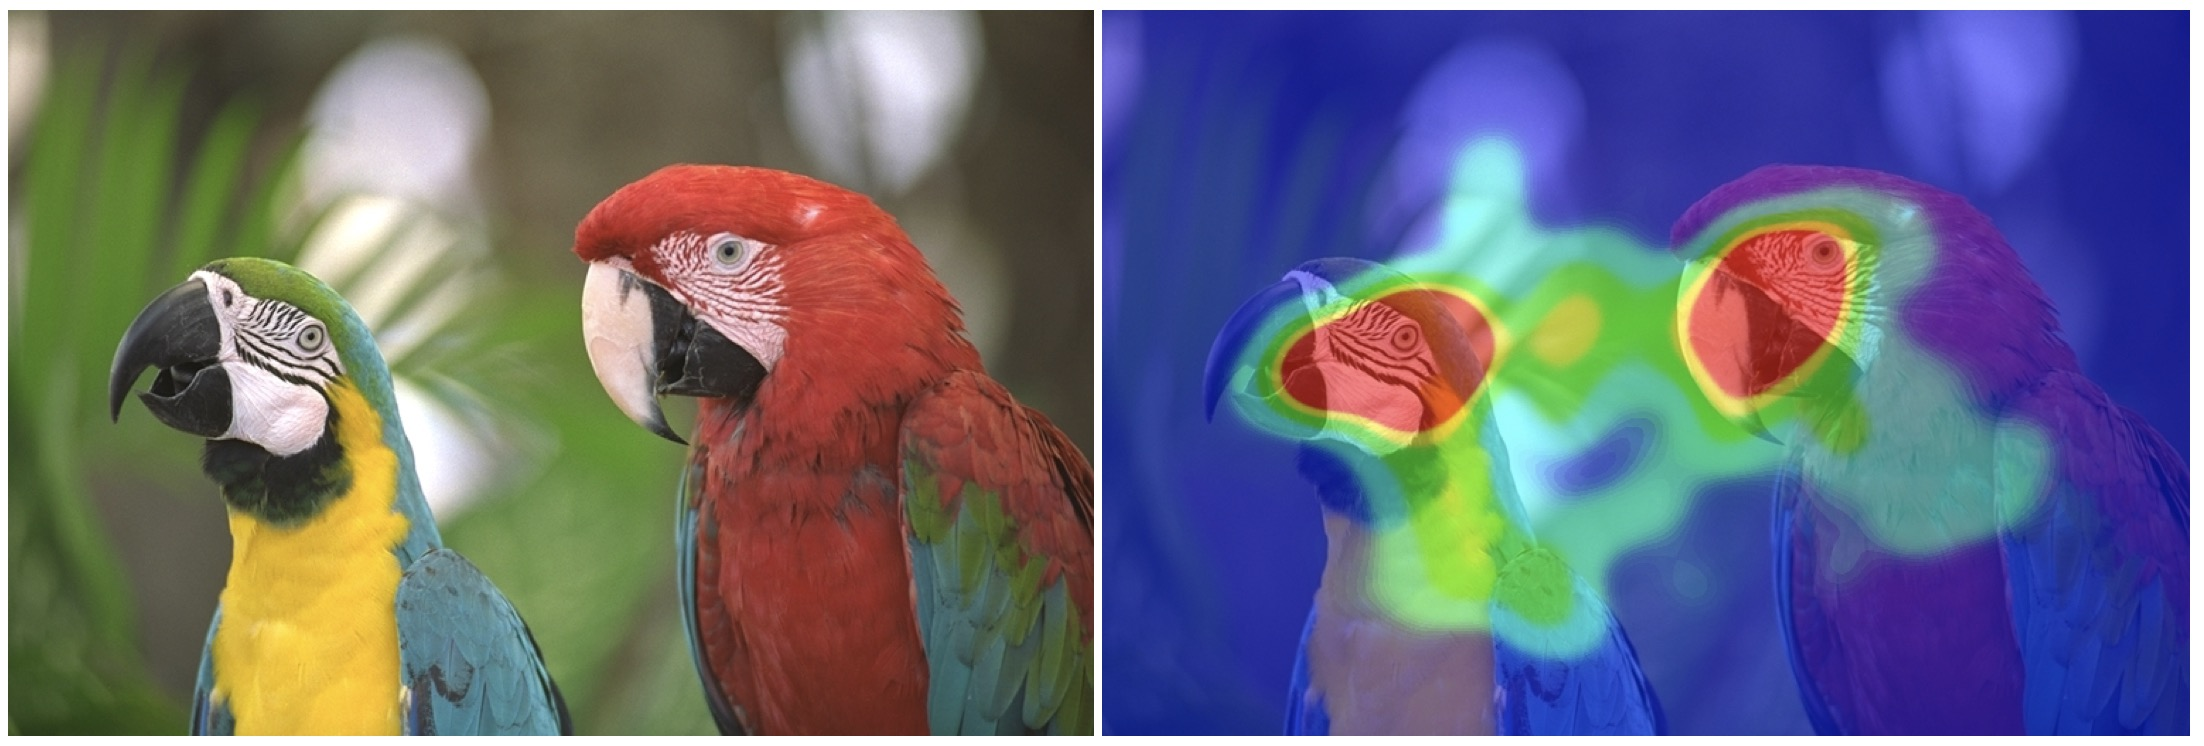

## Описание

Предлагается реализовать нейросетевой алгоритм построения карт внимания

**Требования**:
* Модель должна быть реализована на фреймворке PyTorch
* Для обучения разрешается использовать только обучащую выборку, внешние данные использовать нелья. Однако не запрещено (и, наоборот, приветствуется) использовать аугментации (размножение датасета) и transfer-learning (использование предобученной модели) с дообучением
* Обработка одного кадра должна быть возможна на видеокарте с объемом памяти 24Gb
* Соблюдать [кодекс чести](https://communitystandards.stanford.edu/policies-and-guidance/honor-code). Виновные будут найдены и наказаны

### Оценивание

1. Каждый участник может представить не более 1 алгоритма для финального тестирования  

2. Тестирование будет проводиться на закрытой тестовой выборке, содержащей N (N < 20) тестовых видео. В каждом > 200 кадров.  

3. В качестве метрик будут использованы:

    * Normalized Scanpath Saliency (NSS)
    * Similarity score (SIM)
    * Pearson’s Correlation Coefficient (CC)
    
    [Подробнее про метрики](https://arxiv.org/pdf/1604.03605.pdf)    
4. По итогам тестирования будет составлена общая таблица результатов по каждой из метрик

5. Место алгоритма определяется по формуле: 
$$ \text{Place}_{\text{algo}} = \frac{\text{Place}_{\text{NSS}} + \text{Place}_{\text{SIM}} + \text{Place}_{\text{CC}}}{3}$$

6. Баллы участника зависят от места его алгоритма: 
$$ \text{Score}_{\text{stud}} = \text{score}(\text{Place}_{\text{algo}}) $$

In [1]:
#!pip install torch==2.2.1 opencv-python matplotlib torchvision torchinfo tqdm imageio

In [2]:
import os
import cv2
import tqdm
import torch
import imageio
import itertools
import torchvision
import numpy as np
from torch import nn
from torchinfo import summary
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from utils import normalize_map, padding, padding_fixation

In [3]:
# Удостоверимся, что есть видеокарта
!nvidia-smi -L

GPU 0: NVIDIA A100-SXM4-80GB (UUID: GPU-39f56421-0a72-e5a8-8dde-39060aadf095)


## 1. Подготовка данных

[Дублирование датасета с страницы задания на Google Диск для пользователей Colab [7.2 GB]](https://drive.google.com/file/d/180unBAwWglZE3Z2sNhPyLLetGAudOyVX/view?usp=sharing)

### Датасеты и даталоадеры

Вы можете полностью менять эту реализацию, использовать более одного кадра, добавлять transforms и т.д.!

In [4]:
class DatasetClass(Dataset):
    def __init__(self, path_data, transforms=None, num_frames=1, mode='val'):
        self.input_path_data, self.gt_path_data = path_data
        self.num_frames = num_frames
        self.transforms = transforms
        self.mode = mode
        self.map_idx_to_video = [{'input': os.path.join(self.input_path_data, folder), 
                                  'gt': os.path.join(self.gt_path_data, folder)}
                                 for folder in sorted(os.listdir(self.input_path_data))]
        
    def __len__(self):
        return len(self.map_idx_to_video)

    def __getitem__(self, idx):
        folder = self.map_idx_to_video[idx]
        frames = sorted([x for x in os.listdir(os.path.join(folder['input'], 'frames')) if '.png' in x])
        
        if self.mode == 'val':
            # Берем первый кадр для валидации
            start_idx = self.num_frames
        else:
            start_idx = np.random.randint(0, len(frames) - self.num_frames + 1)
        
        end_idx = start_idx + self.num_frames
        
        fragment = []
        for fname in frames[start_idx:end_idx]:
            frame = padding(
                        cv2.cvtColor(
                            cv2.imread(os.path.join(folder['input'], 'frames', fname)), 
                        cv2.COLOR_BGR2RGB)
                    ).astype('float32') / 255.
            fragment.append(self.transforms(frame))
        
        # Предсказываем карту внимания для последнего кадра в случайном подмножестве frames
        # Не забываем делать паддинг и нормализацию для единообразия
        saliency = normalize_map(padding(
                 cv2.imread(os.path.join(folder['gt'], 'gt_saliency', frames[end_idx - 1]), 
                 cv2.IMREAD_GRAYSCALE)))[np.newaxis].astype('float32')
        
        # Бейзлайн модель использует функцию потерь, основанную только на карте saliency
        # Но если понадобится, вы можете использовать и карты фиксаций
#         fixations = padding_fixation(
#                             cv2.imread(os.path.join(folder['gt'], 'gt_fixations', frames[end_idx - 1]), 
#                             cv2.IMREAD_GRAYSCALE))[np.newaxis].astype('float32')
        
        return fragment, saliency


# Бесконечное равномерное семплирование из датасета
class InfiniteSampler(torch.utils.data.sampler.Sampler):
    def __init__(self, size):
        self.size = size

    def _infinite_indices(self):
        g = torch.Generator()
        while True:
            yield from torch.randperm(self.size, generator=g)

    def __iter__(self):
        yield from itertools.islice(self._infinite_indices(), 0, None, 1)

In [5]:
class DatasetClassWithOneObserver(DatasetClass):

    def __getitem__(self, idx):
        folder = self.map_idx_to_video[idx]
        frames = sorted([x for x in os.listdir(os.path.join(folder['input'], 'frames')) if '.png' in x])
        
        if self.mode == 'val':
            # Берем первый кадр для валидации
            start_idx = self.num_frames
            observer_idx = '00'
        else:
            start_idx = np.random.randint(0, len(frames) - self.num_frames + 1)
            observer_idx = np.random.choice(os.listdir(os.path.join(folder['input'], 'observers')))
        
        end_idx = start_idx + self.num_frames
        
        fragment = []
        observer_maps = []
        for fname in frames[start_idx:end_idx]:
            frame = padding(
                        cv2.cvtColor(
                            cv2.imread(os.path.join(folder['input'], 'frames', fname)), 
                        cv2.COLOR_BGR2RGB)
                    ).astype('float32') / 255.
            fragment.append(self.transforms(frame))
            
            observer_saliency = normalize_map(padding(
                 cv2.imread(os.path.join(folder['input'], 'observers', observer_idx,  'gaussians', frames[end_idx - 1]), 
                 cv2.IMREAD_GRAYSCALE)))[np.newaxis].astype('float32')
            observer_maps.append(observer_saliency)
        
        # Предсказываем карту внимания для последнего кадра в случайном подмножестве frames
        # Не забываем делать паддинг и нормализацию для единообразия
        saliency = normalize_map(padding(
                 cv2.imread(os.path.join(folder['gt'], 'gt_saliency', frames[end_idx - 1]), 
                 cv2.IMREAD_GRAYSCALE)))[np.newaxis].astype('float32')
        
        return fragment, observer_maps, saliency

In [6]:
# Нормализация параметрами из ImageNet
normalization = torchvision.transforms.Normalize(
                    mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225])

denormalization = torchvision.transforms.Normalize(
                mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
                std=[1/0.229, 1/0.224, 1/0.225])

# Вы также можете попробовать использовать аугментации, но будьте аккуратны
# требуются преобразования, не меняющие области внимания, а также если вы используете
# несколько кадров, то пространственные преобразования между кадрами должны быть согласованы!
im_transform = torchvision.transforms.Compose([
                    torchvision.transforms.ToTensor(),
                    normalization
               ])

In [7]:
DATA_TRAIN = ['./public_tests/01_test_file_input/train/', './public_tests/01_test_file_gt/train/']
DATA_VAL = ['./public_tests/01_test_file_input/test/', './public_tests/01_test_file_gt/test/']

In [8]:
data_train = DatasetClassWithOneObserver(DATA_TRAIN, transforms=im_transform, num_frames=1, mode='train')
data_valid = DatasetClassWithOneObserver(DATA_VAL, transforms=im_transform, num_frames=1, mode='val')

train_loader = DataLoader(data_train, batch_size=8, sampler=InfiniteSampler(len(data_train)), 
                          num_workers=2, pin_memory=True)

valid_loader = DataLoader(data_valid, batch_size=1, shuffle=False, pin_memory=True)

Посмотрим на случайный пример из датасета

In [9]:
fragment, observer_maps, saliency = next(iter(valid_loader))

(-0.5, 383.5, 215.5, -0.5)

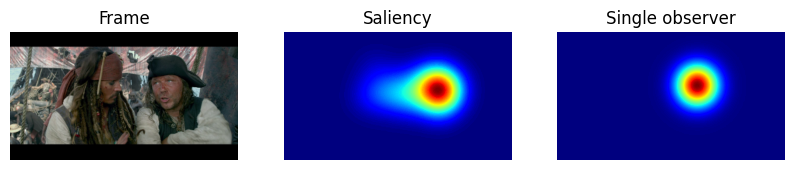

In [10]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 6))

ax1.imshow(denormalization(fragment[0][0]).permute(1, 2, 0))
ax1.set_title('Frame')
ax1.axis('off')
ax2.imshow(saliency[0][0], cmap='jet')
ax2.set_title('Saliency')
ax2.axis('off')
ax3.imshow(observer_maps[0][0][0], cmap='jet')
ax3.set_title('Single observer')
ax3.axis('off')

## 2. Создадим класс нашей модели

Так как данных мало, предлагается использовать технику **transfer learning**, используя нейросеть, предобученную на сегментацию изображений, например, **Deeplabv3**. 

Модель построим из трех частей:
* Сверточный Encoder, например, ResNet50
* Пирамидальный пулинг ASPP состоящий из нескольких параллельных сверток с разным рецептивным полем благодаря dilation convolution
* Сверточный Decoder, получающий финальное предсказание

**Архитектура Deeplab**:

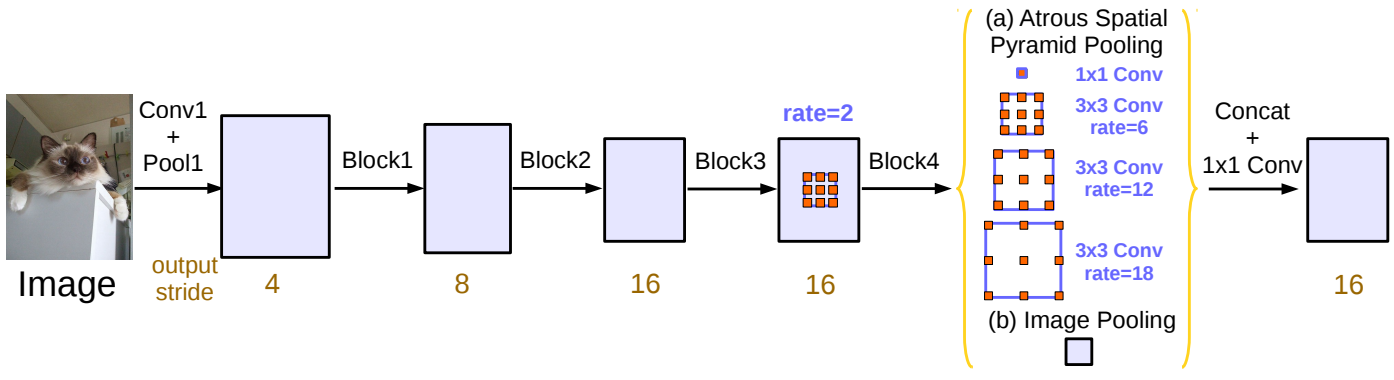

**Dilation convolution**:

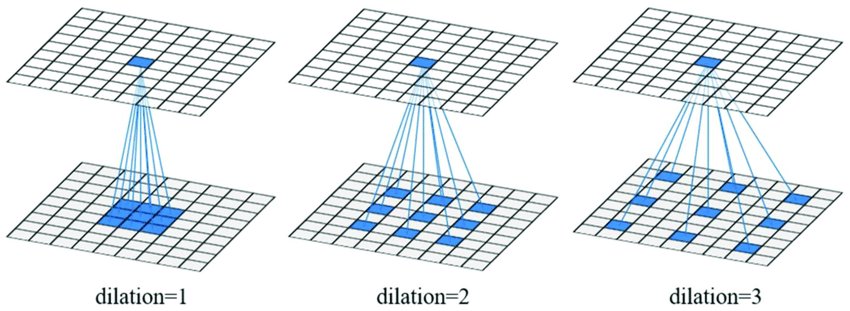

В моделе, доступной в библиотеке `torchvision.models`, Decoder получает изображение в низком разрешении и имеет 21 класс (количество выходных каналов):

In [11]:
torchvision.models.segmentation.deeplabv3_resnet50(
    weights=torchvision.models.segmentation.DeepLabV3_ResNet50_Weights.DEFAULT).classifier[-1]

Conv2d(256, 21, kernel_size=(1, 1), stride=(1, 1))

В нашей же задаче требуется предсказания одноканального изображения с разрешением, как у исходного. Поэтому сделаем свой декодер, постепенно повышая разрешение в 2 раза. На последнем слое применим нормализацию в 0-1.

Encoder ожидает на вход 3х-канальное изображение:

In [12]:
torchvision.models.segmentation.deeplabv3_resnet50(
    weights=torchvision.models.segmentation.DeepLabV3_ResNet50_Weights.DEFAULT).backbone.conv1

Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

Документация PyTorch: https://pytorch.org/docs/stable/index.html
        
Ваша модель должна быть описана в файле `saliency_single_observer.py`, этот файл **СДАЕТСЯ** в проверяющую систему!

Файл `saliency_single_observer.py` должен быть самодостаточным, т.е. содержать все необходимые import-ы и функции для создания и запуска модели.

In [13]:
from saliency_single_observer import SingleObserverSaliencyModel

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [15]:
model = SingleObserverSaliencyModel().to(device)

In [16]:
summary(model, input_size=(8, 4, 216, 384))

Layer (type:depth-idx)                        Output Shape              Param #
SingleObserverSaliencyModel                   [8, 1, 216, 384]          --
├─IntermediateLayerGetter: 1-1                [8, 2048, 27, 48]         --
│    └─Conv2d: 2-1                            [8, 64, 108, 192]         12,544
│    └─BatchNorm2d: 2-2                       [8, 64, 108, 192]         128
│    └─ReLU: 2-3                              [8, 64, 108, 192]         --
│    └─MaxPool2d: 2-4                         [8, 64, 54, 96]           --
│    └─Sequential: 2-5                        [8, 256, 54, 96]          --
│    │    └─Bottleneck: 3-1                   [8, 256, 54, 96]          75,008
│    │    └─Bottleneck: 3-2                   [8, 256, 54, 96]          70,400
│    │    └─Bottleneck: 3-3                   [8, 256, 54, 96]          70,400
│    └─Sequential: 2-6                        [8, 512, 27, 48]          --
│    │    └─Bottleneck: 3-4                   [8, 512, 27, 48]          379,39

## 3. Зададим функцию потерь

Будем использовать дивергенцию [Кульбака-Лейблера](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence), сравнивая предсказанное распределение с эталонной картой внимания. Вы так же можете использовать другие функции потерь при обучении.

In [17]:
def kld(y_pred, y_true, eps=1e-7):
    """This function computes the Kullback-Leibler divergence between ground
       truth saliency maps and their predictions. Values are first divided by
       their sum for each image to yield a distribution that adds to 1.
    Args:
        y_true (tensor, float32): A 4d tensor that holds the ground truth
                                  saliency maps with values between 0 and 255.
        y_pred (tensor, float32): A 4d tensor that holds the predicted saliency
                                  maps with values between 0 and 1.
        eps (scalar, float, optional): A small factor to avoid numerical
                                       instabilities. Defaults to 1e-7.
    Returns:
        tensor, float32: A 0D tensor that holds the averaged error.
    """

    sum_true = torch.sum(y_true, dim=(1, 2, 3), keepdim=True)
    y_true = y_true / (eps + sum_true)

    sum_pred = torch.sum(y_pred, dim=(1, 2, 3), keepdim=True)
    y_pred = y_pred / (eps + sum_pred)
    
    loss = y_true * torch.log(eps + y_true / (eps + y_pred))
    loss = torch.mean(torch.sum(loss, dim=(1, 2, 3)))

    return loss

## 4. Обучим модель

__Пайплайн обучения__:
* Определить __таргет__. В нашей задаче это эталонная карта внимания
* Определить __функцию потерь (loss)__. Используем KLD из предыдущего этапа
* Выбрать __оптимизатор__. Чтобы всё быстро заработало, возьмем `Adam/AdamW` c [lr=3e-4](https://www.urbandictionary.com/define.php?term=Karpathy%20Constant)

In [18]:
# Берем оптимизатор AdamW
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)

# Рекомендуется увеличить следующие значения т.к.
# они выбраны для демонстрации, а не качества модели

# Число эпох
NUM_EPOCHS = 10
# Делаем 50 случайных семплирований из датасета на эпоху
NUM_STEPS = 50

In [19]:
for epoch in range(NUM_EPOCHS):
    train_losses = []
    valid_losses = []

    # Часть слоев сети имеет два режима - train и eval
    # Важно переводить из одного в другой при обучении/тестировании
    model.train()

    ##################
    ### TRAIN LOOP ###
    ##################
    loop = tqdm.tqdm(itertools.islice(train_loader, NUM_STEPS), total=NUM_STEPS)
    for fragment, one_observer, gt_saliency in loop:
        # Set to zero the parameter gradients for the current batch
        optimizer.zero_grad()

        # Prediction for one frame
        fragment = fragment[0].cuda()
        gt_saliency = gt_saliency.cuda()
        one_observer = one_observer[0].cuda()
        
        fragment_with_one_observer = torch.cat((fragment, one_observer), dim=1)
        pred_saliency = model(fragment_with_one_observer)

        # Calculate loss, make backward pass and update the parameters
        loss = kld(pred_saliency, gt_saliency)
        loss.backward()
        optimizer.step()

        loss_value = loss.item()
        loop.set_postfix(loss=loss_value)
        train_losses.append(loss_value)
    

    #######################
    ### VALIDATION LOOP ###
    #######################
    with torch.no_grad():
        model.eval()
        for fragment, one_observer, gt_saliency in tqdm.tqdm(valid_loader, total=len(valid_loader)):
            optimizer.zero_grad()
            fragment = fragment[0].cuda()
            gt_saliency = gt_saliency.cuda()
            one_observer = one_observer[0].cuda()

            fragment_with_one_observer = torch.cat((fragment, one_observer), dim=1)
            pred_saliency = model(fragment_with_one_observer)

            loss = kld(pred_saliency, gt_saliency)
            valid_losses.append(loss.item())
        print("| Epoch: ", epoch, 
              "| Val Loss: ", np.mean(valid_losses), 
              "| Train Loss: ", np.mean(train_losses))

100%|██████████| 3/3 [00:00<00:00, 11.13it/s]

| Epoch:  0 | Val Loss:  0.45534321665763855 | Train Loss:  0.6122541737556457



100%|██████████| 3/3 [00:00<00:00, 12.27it/s]

| Epoch:  1 | Val Loss:  0.40258293350537616 | Train Loss:  0.4304718714952469



100%|██████████| 3/3 [00:00<00:00, 11.91it/s]

| Epoch:  2 | Val Loss:  0.288569043080012 | Train Loss:  0.4019764757156372



100%|██████████| 3/3 [00:00<00:00, 12.61it/s]

| Epoch:  3 | Val Loss:  0.3885070780913035 | Train Loss:  0.41201020300388336



100%|██████████| 3/3 [00:00<00:00,  9.88it/s]

| Epoch:  4 | Val Loss:  0.41874605417251587 | Train Loss:  0.4122008267045021



100%|██████████| 3/3 [00:00<00:00, 10.68it/s]

| Epoch:  5 | Val Loss:  0.2235511839389801 | Train Loss:  0.3856837475299835



100%|██████████| 3/3 [00:00<00:00,  9.26it/s]

| Epoch:  6 | Val Loss:  0.2144584208726883 | Train Loss:  0.3431571587920189



100%|██████████| 3/3 [00:00<00:00, 12.93it/s]

| Epoch:  7 | Val Loss:  0.3624043216307958 | Train Loss:  0.3641256356239319



100%|██████████| 3/3 [00:00<00:00, 11.96it/s]

| Epoch:  8 | Val Loss:  0.2868318359057109 | Train Loss:  0.3584832298755646



100%|██████████| 3/3 [00:00<00:00, 10.26it/s]

| Epoch:  9 | Val Loss:  0.5922253131866455 | Train Loss:  0.3423562940955162


## 5. Протестируем модель

Сохраняем веса модели (этот файл **СДАЕТСЯ** в проверяющую систему)

In [20]:
torch.save(model, 'saliency_single_observer.pth')

В качестве метрик будут использованы:
* Normalized Scanpath Saliency (NSS)
* Similarity score (SIM)
* Pearson’s Correlation Coefficient (CC)

[Подробнее про метрики](https://arxiv.org/pdf/1604.03605.pdf)

In [21]:
def nss(s_map, gt):
    x,y = np.where(gt)
    s_map_norm = (s_map - np.mean(s_map))/(np.std(s_map) + 1e-7)
    temp = []
    for i in zip(x,y):
        temp.append(s_map_norm[i[0], i[1]])
    return np.mean(temp)

In [22]:
def similarity(s_map, gt):
    s_map = s_map / (np.sum(s_map) + 1e-7)
    gt = gt / (np.sum(gt) + 1e-7)
    return np.sum(np.minimum(s_map, gt))

In [23]:
def cc(s_map, gt):
    a = (s_map - np.mean(s_map))/(np.std(s_map) + 1e-7)
    b = (gt - np.mean(gt))/(np.std(gt) + 1e-7)
    r = (a*b).sum() / np.sqrt((a*a).sum() * (b*b).sum() + 1e-7)
    return r

Помимо описания класса модели в **СДАВАЕМОМ** файле `saliency_single_observer.py` необходимо описать класс `SingleObserverSaliencyEvaluator`, выполняющий логику загрузки модели и инференса на заданном видео с сохранением предсказаний.

Функция принимает путь до входных последовательностей кадров и путь до выходной папки предсказаний.

В этой функции нужно описать процесс загрузки весов модели получение карт внимания для всех входных видеопоследовательностей. Если ваша модель использует более одного кадра или требует дополнительных преобразований входа, реализуйте их внутри этой функции.

In [24]:
import os
from saliency_single_observer import SingleObserverSaliencyEvaluator

NUM_OBSERVERS_TO_CHECK = 3

# Делаем предсказания моделью для всех входных кадров видео
for video_name in sorted(os.listdir(DATA_VAL[0])):
    for observer_id in sorted(os.listdir(os.path.join(DATA_VAL[0], video_name, 'observers')))[:NUM_OBSERVERS_TO_CHECK]:
        
        # Пересоздаем модель каждый раз, чтобы избежать data-leak между различными зрителями
        evaluator = SingleObserverSaliencyEvaluator(model_path='saliency_single_observer.pth')
        video_frames_path = os.path.join(DATA_VAL[0], video_name, 'frames')
        observer_data_path = os.path.join(DATA_VAL[0], video_name, 'observers', observer_id)
        output_saliency_path = os.path.join('./outputs', video_name, 'observer_' + str(observer_id))
        os.makedirs(output_saliency_path, exist_ok=True)
    
        evaluator.evaluate(video_frames_path, observer_data_path, output_saliency_path)

100%|██████████| 450/450 [00:27<00:00, 16.58it/s]


In [25]:
# Функция вычисления тестовых метрик
from utils import calculate_single_observer_metrics

In [27]:
calculate_single_observer_metrics('./outputs/', DATA_VAL[1], num_observers=3)

100%|██████████| 450/450 [00:06<00:00, 74.54it/s]


{'sim': 0.501303672660819, 'nss': 1.8504584636522106, 'cc': 0.5417532095532906}

In [28]:
# Аналогичный вызов, которым будет тестироваться ваша модель в проверочной системе
# !python3 run.py ./private_tests/

In [29]:
# Сделаем анимацию полученной карты внимания
def gif_creator(input_frames_path, predictions_path, gif_name='out.gif'):

    with imageio.get_writer(gif_name, mode="I") as writer:
        # Берем каждый 5ый кадр для ускорения
        for input_name in tqdm.tqdm(sorted(os.listdir(input_frames_path)[::5])):
            if '.png' not in input_name:
                continue
                
            pred_sm = cv2.imread(os.path.join(predictions_path, input_name), 0)
            # Invertion for colormap
            norm_sm = ((1 - normalize_map(pred_sm)) * 255).astype(np.uint8)
            heatmap = cv2.applyColorMap(norm_sm, cv2.COLORMAP_JET)
            frame = cv2.imread(os.path.join(input_frames_path, input_name))[:, :, ::-1]
            
            alpha = 0.7
            alpha_blended = np.clip(alpha * frame + (1 - alpha) * heatmap, 0, 255).astype(np.uint8)
            
            writer.append_data(alpha_blended)

In [30]:
gif_creator(input_frames_path=os.path.join(DATA_VAL[0], '00/frames'),
            predictions_path=os.path.join('./outputs/00/observer_00/'))

100%|██████████| 90/90 [00:01<00:00, 53.51it/s]


In [ ]:
from IPython.display import Image

Image(open('out.gif','rb').read())

## 6. Дальнейшие шаги

Для улучшения качества вашей модели можно попробовать следующие этапы:
* Сделать более информативную валидацию, например, добавив подсчет тестовых метрик прямо в validation loop
* Попробовать обучать большее число эпох, использовать регуляризацию, например, через Dropout
* Добавить skip-connection в Encoder-Decoder
* Сделать аугментации ([albumentations](https://github.com/albumentations-team/albumentations)). Будьте аккуранты с преобразованиями, которые могут потенциально изменить эталонные карты внимания. Начать можно с горизонтальных отражений
* Попробовать другие архитектуры, функции потерь и стратегии обучения
* Использовать информацию из более чем одного кадра (3D Conv/LSTM/GRU/любой другой способ агрегации). Обратите внимание: даже если ваш метод требует окно из кадров, тестирование всё равно будет учитывать все кадры видео. Во время тестирования вы можете искуственно дублировать первый кадр для накопления нужной ширины окна для предсказания.
* Поискать методы, решающие похожие задачи
* Пофантазировать и вдохновиться